<a href="https://colab.research.google.com/github/JohnYCLam/MachineLearning/blob/main/Reinforcement_Learning_Multi_armed_Bandit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-armed Bandit and Experiment Classes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter

In [2]:
def random_argmax(value_list):
    list_size = len(value_list)
    permute_seq = np.random.permutation(range(1, list_size +1))
    values = np.asarray(value_list)
    criterion = values.max()
    filter = (values == criterion)
    max_index = np.argmax(permute_seq * filter)
    #print(permute_seq, criterion, filter, permute_seq * filter, max_index)
    return max_index

In [42]:
class Base_MAB:

    def __init__(self, true_mean, *args):
        self.true_mean = true_mean
        if args != ():
            self.arg = args[0]
        self.estimate_mean = 0.0
        self.n_steps = 0

    def reset(self):
        if hasattr(self, 'arg'):
            self.__init__(self.true_mean, self.arg)
        else:
            self.__init__(self.true_mean)

    def return_reward(self):
        reward = max(0.0, self.true_mean + np.random.randn())
        return reward

    def update(self, reward):
        self.n_steps += 1
        self.estimate_mean = (1 - 1/self.n_steps) * self.estimate_mean + 1/self.n_steps * reward

In [43]:
class Base_Experiment:

    def __init__(self, mab, true_means, *args):
        self.mab = mab
        self.true_means = true_means
        if args != ():
            self.arg = args[0]
            self.mabs = [mab(true_mean, self.arg) for true_mean in true_means]
        else:
            self.mabs = [mab(true_mean) for true_mean in true_means]
        self.cumulative_reward = 0.0
        self.cumulative_rewards = [0.0]
        self.n_mabs = len(self.mabs)
        self.mabs_selected = []
        self.mean_rewards = None

    def reset(self):
        if hasattr(self, 'arg'):
            self.__init__(self.mab, self.true_means, self.arg)
        else:
            self.__init__(self.mab, self.true_means)

    def select(self):
        current_means = [mab.estimate_mean for mab in self.mabs]
        max_index = random_argmax(current_means)
        return max_index

    def update(self, max_index):
        mab = self.mabs[max_index]
        reward = mab.return_reward()
        mab.update(reward)
        self.cumulative_reward += reward
        self.cumulative_rewards.append(self.cumulative_reward)

    def run(self, n_steps):

        self.mean_rewards = np.zeros((n_steps + 1, self.n_mabs))

        for n in range(1, n_steps + 1):
            max_index = self.select()
            self.update(max_index)
            self.mabs_selected.append(max_index)
            self.mean_rewards[n, :] = [mab.estimate_mean for mab in self.mabs]

In [5]:
def run_epochs(Experiment, MAB, true_means, epoch_length = 30, epochs = 50, **kwargs):
    mean_rewards_per_param = []
    percent_optimal_mab_selected_per_param = []
    optimal_index = true_means.index(max(true_means))

    for param_list in kwargs.values():
        for param in param_list:
            mean_reward = 0.0
            percent_optimal_mab_selected = 0.0
            experiment = Experiment(MAB, true_means, param)

            for epoch in range(1, epochs + 1):
                #print(f'a: {experiment.epsilon}')
                experiment.run(epoch_length)
                #print(f'r: {experiment.epsilon}')
                mean_reward =  (mean_reward * (epoch - 1) + (experiment.cumulative_reward/epoch_length)) / epoch
                percent_optimal_mab_selected =  (percent_optimal_mab_selected * (epoch - 1) + Counter(experiment.mabs_selected)[optimal_index]) / epoch
                experiment.reset()
                #print(f'b: {experiment.epsilon}')
            mean_rewards_per_param.append(mean_reward)
            percent_optimal_mab_selected_per_param.append(percent_optimal_mab_selected/epoch_length)

    return mean_rewards_per_param, percent_optimal_mab_selected_per_param

In [6]:
def percent_mabs_selected_per_timestep(experiment, time_step):
    percent_mabs_selected = np.zeros((time_step + 1, experiment.n_mabs))
    for t in range(1, time_step + 1):
        mab_selected = experiment.mabs_selected[t - 1]
        percent_mabs_selected[t, :] = percent_mabs_selected[t - 1, :]
        percent_mabs_selected[t, mab_selected] += 1

    percent_mabs_selected = percent_mabs_selected[1:, :] / np.array(range(1, 121)).reshape((-1,1))

    return percent_mabs_selected

In [7]:
true_means = [k*2 + 2 for k in range(1, 6)]

#Greedy Algorithm

In [ ]:
#Base case is same as Greedy Approach
experiment = Base_Experiment(Base_MAB, true_means)
experiment.reset()
experiment.run(5)

In [ ]:
experiment.mabs_selected

[2, 2, 2, 2, 2]

In [ ]:
experiment.mean_rewards

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 8.51738744, 0.        , 0.        ],
       [0.        , 0.        , 7.89122757, 0.        , 0.        ],
       [0.        , 0.        , 7.21617375, 0.        , 0.        ],
       [0.        , 0.        , 7.2143476 , 0.        , 0.        ],
       [0.        , 0.        , 7.65734419, 0.        , 0.        ]])

In [ ]:
experiment.cumulative_reward

40.82986860331201

In [ ]:
experiment = Base_Experiment(Base_MAB, true_means)
mabs_selected = []
for _ in range(100):
    experiment.reset()
    experiment.run(1)
    mabs_selected.append(experiment.mabs_selected[0])

In [ ]:
#roughly 20 for each mab
Counter(mabs_selected)

Counter({3: 25, 1: 21, 0: 17, 2: 16, 4: 21})

# Optimistic Greedy Algorithm

In [ ]:
class Optimistic_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.estimate_mean = self.arg

    def update(self, reward):
        self.n_steps += 1
        if self.arg == 0.0:
            self.estimate_mean = (1 - 1/self.n_steps) * self.estimate_mean + 1/self.n_steps * reward
        else:
            self.estimate_mean = (1 - 1/(self.n_steps + 1)) * self.estimate_mean + 1/(self.n_steps + 1) * reward

In [ ]:
class Optimistic_Experiment(Base_Experiment):
    def run(self, n_steps):

        self.mean_rewards = np.full((n_steps + 1, self.n_mabs), self.arg)

        for n in range(1, n_steps + 1):
            max_index = self.select()
            self.update(max_index)
            self.mabs_selected.append(max_index)
            self.mean_rewards[n, :] = [mab.estimate_mean for mab in self.mabs]

In [ ]:
# Set initial estimate to a high value for exploration at the early stage
# last param is initial estimate
optim_greedy_exp = Optimistic_Experiment(Optimistic_MAB, true_means, 20.0)
optim_greedy_exp.run(30)

In [ ]:
optim_greedy_exp.mabs_selected

[3,
 1,
 4,
 2,
 0,
 4,
 3,
 4,
 4,
 4,
 2,
 4,
 4,
 3,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [ ]:
optim_greedy_exp.mean_rewards

array([[20.        , 20.        , 20.        , 20.        , 20.        ],
       [20.        , 20.        , 20.        , 15.50598078, 20.        ],
       [20.        , 13.3269741 , 20.        , 15.50598078, 20.        ],
       [20.        , 13.3269741 , 20.        , 15.50598078, 16.45360039],
       [20.        , 13.3269741 , 14.02213644, 15.50598078, 16.45360039],
       [11.74974044, 13.3269741 , 14.02213644, 15.50598078, 16.45360039],
       [11.74974044, 13.3269741 , 14.02213644, 15.50598078, 15.09097837],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 15.09097837],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 14.4809574 ],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 14.07603031],
       [11.74974044, 13.3269741 , 14.02213644, 13.38516472, 13.78471446],
       [11.74974044, 13.3269741 , 11.92514377, 13.38516472, 13.78471446],
       [11.74974044, 13.3269741 , 11.92514377, 13.38516472, 13.70386629],
       [11.74974044, 13.3269741 , 11.9

In [ ]:
optim_greedy_exp.cumulative_reward

321.61651795594395

In [ ]:
mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(Optimistic_Experiment, Optimistic_MAB, true_means, initial_estimates = range(100))

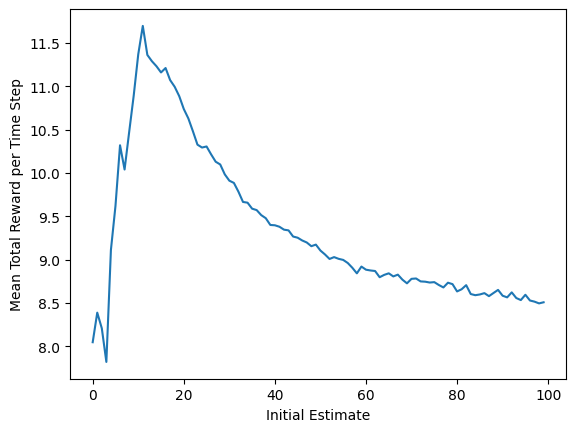

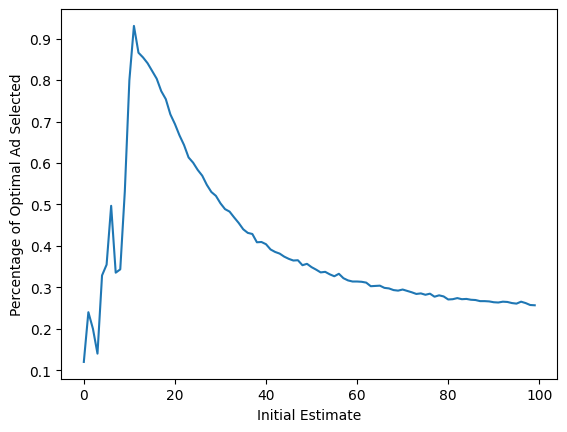

In [ ]:
plt.plot(mean_rewards_per_param)
plt.xlabel('Initial Estimate')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(percent_optimal_mab_selected_per_param)
plt.xlabel('Initial Estimate')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

# Epsilon-Greedy Algorithm

In [ ]:
class Eps_Greedy_Experiment(Base_Experiment):

    def select(self):
        p = np.random.random()
        if p < self.arg:
            max_index = np.random.choice(self.n_mabs)

        else:
            current_means = [mab.estimate_mean for mab in self.mabs]
            max_index = random_argmax(current_means)

        return max_index

In [ ]:
experiment = Eps_Greedy_Experiment(Base_MAB, true_means, 1.0)

In [ ]:
experiment.run(500)

In [ ]:
#same as uniformly random selection
#roughly 100 counts for each mab
Counter(experiment.mabs_selected)

Counter({1: 110, 3: 97, 0: 89, 4: 94, 2: 110})

In [ ]:
experiment.cumulative_reward

3979.7878878228667

In [ ]:
experiment.mean_rewards

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  5.7698423 ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  5.7698423 ,  0.        ,  8.96669219,  0.        ],
       ...,
       [ 4.20877723,  5.95569277,  8.11460661,  9.98021347, 11.84870122],
       [ 4.20877723,  5.95569277,  8.13031494,  9.98021347, 11.84870122],
       [ 4.20877723,  5.95569277,  8.13567672,  9.98021347, 11.84870122]])

In [ ]:
epsilons = np.array(range(21))/20
mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(Eps_Greedy_Experiment, Base_MAB, true_means, epoch_length = 50, epochs = 100, epsilons = epsilons)

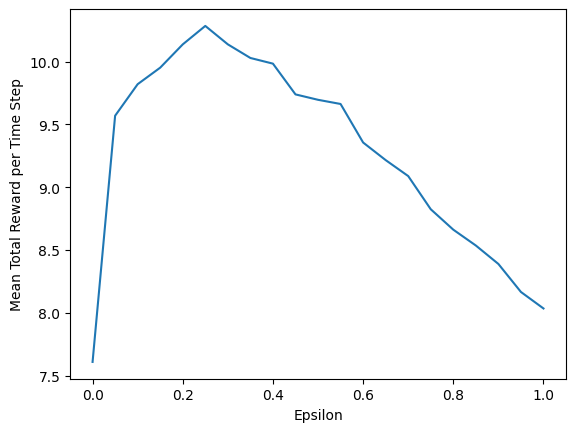

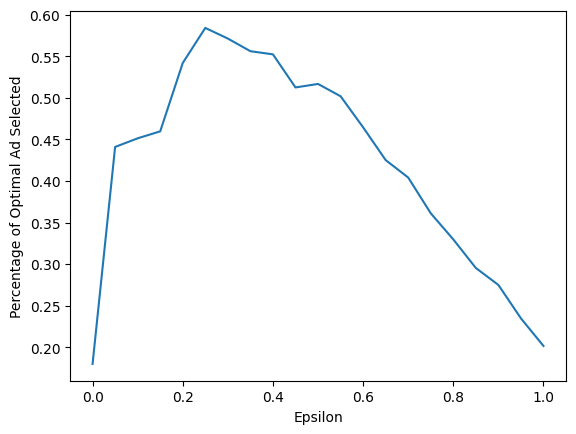

In [ ]:
plt.plot(epsilons, mean_rewards_per_param)
plt.xlabel('Epsilon')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(epsilons, percent_optimal_mab_selected_per_param)
plt.xlabel('Epsilon')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

#Exponential Weight Algorithm (EXP3)

In [44]:
class EXP3_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.w = 1.0

In [45]:
class EXP3_Experiment(Base_Experiment):

    def select(self):
        sum_w = np.array([mab.w for mab in self.mabs]).sum()
        probs = [(1 - self.arg) * mab.w/sum_w + self.arg/self.n_mabs for mab in self.mabs]
        selected_index = np.random.choice(range(self.n_mabs), p = probs)
        selected_prob = probs[selected_index]
        return selected_index, selected_prob

    def update(self, selected_index, selected_prob):
        selected_mab = self.mabs[selected_index]
        reward = selected_mab.return_reward()
        selected_mab.update(reward)
        self.cumulative_reward += reward
        self.cumulative_rewards.append(self.cumulative_reward)
        selected_mab.w *= np.exp((self.arg / self.n_mabs) * (reward/ selected_prob))

    def run(self, n_steps):

        self.mean_rewards = np.zeros((n_steps + 1, self.n_mabs))

        for n in range(1, n_steps + 1):
            selected_index, selected_prob = self.select()
            self.update(selected_index, selected_prob)
            self.mabs_selected.append(selected_index)
            self.mean_rewards[n, :] = [mab.estimate_mean for mab in self.mabs]

In [56]:
true_means = [k*2 + 2 for k in range(1, 6)]
time_step = 120
experiment = EXP3_Experiment(EXP3_MAB, true_means, 0.2) #last param is gamma
experiment.run(time_step)

In [57]:
Counter(experiment.mabs_selected)

Counter({2: 10, 1: 1, 4: 100, 0: 5, 3: 4})

In [58]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

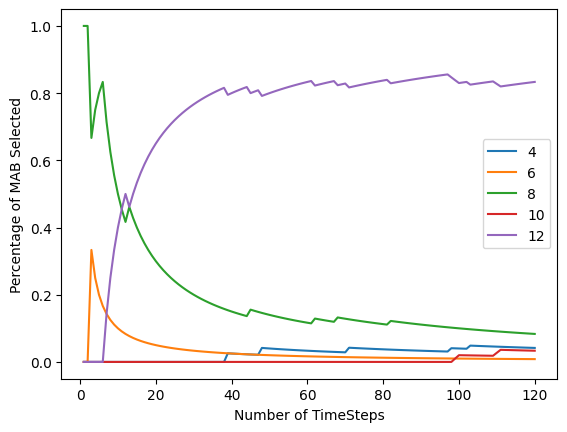

In [59]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

In [61]:
gammas = np.array(range(21))/20

mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(EXP3_Experiment, EXP3_MAB, true_means, epoch_length = 120, epochs = 80, gammas = gammas)


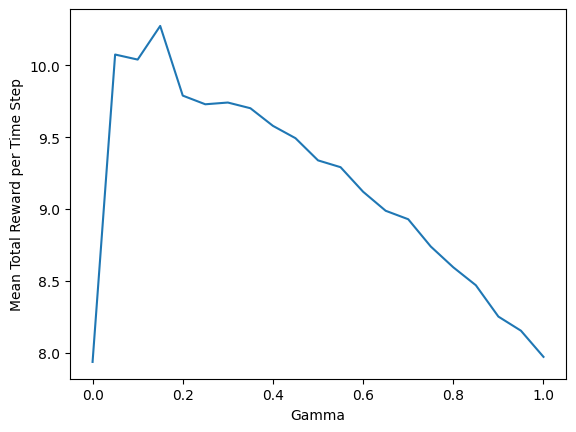

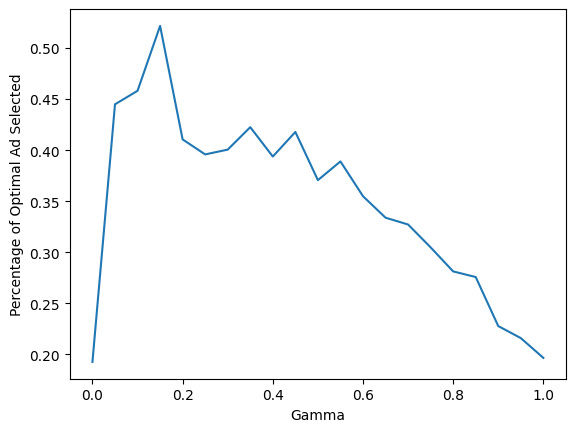

In [62]:
plt.plot(gammas, mean_rewards_per_param)
plt.xlabel('Gamma')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(gammas, percent_optimal_mab_selected_per_param)
plt.xlabel('Gamma')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

#Upper Confidence Bound (UCB) Algorithm

In [ ]:
# General UCB formula for Action A_t chosen at time step t:
# A_t = argmax_{a} [Q_t(a) + c*sqrt(log(t)/N_t(a)], for all actions a
# where Q_t (a) is the estimated value of mean rewward Q(a) at time t
# N_t (a) is the number of times that action a has been selected prior to time t
# c is the hyperparameter which controls the 'height' of upper confidence bound,
# or in another view, the strength of exploration

class UCB_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.estimate_mean = float('inf')

    def confidence_bound(self, time_step):
        if self.n_steps == 0:
            return float('inf')
        else:
            return self.arg * np.sqrt(np.log(time_step) / self.n_steps)

    def update(self, reward):
        if self.estimate_mean == float('inf'):
            self.estimate_mean = 0.0

        self.n_steps += 1
        self.estimate_mean = (1 - 1/self.n_steps) * self.estimate_mean + 1/self.n_steps * reward

In [ ]:
class UCB_Experiment(Base_Experiment):
    def select(self, time_step):
        current_means = [mab.estimate_mean + mab.confidence_bound(time_step) for mab in self.mabs]
        max_index = random_argmax(current_means)
        return max_index

    def run(self, n_steps):

        self.mean_rewards = np.full((n_steps + 1, self.n_mabs), float('inf'))

        for t in range(1, n_steps + 1):
            max_index = self.select(t)
            self.update(max_index)
            self.mabs_selected.append(max_index)
            self.mean_rewards[t, :] = [mab.estimate_mean for mab in self.mabs]


In [ ]:
confidence_levels = np.array(range(21))/10

mean_rewards_per_param, percent_optimal_mab_selected_per_param = run_epochs(UCB_Experiment, UCB_MAB, true_means, epoch_length = 120, epochs = 80, confidence_levels = confidence_levels)

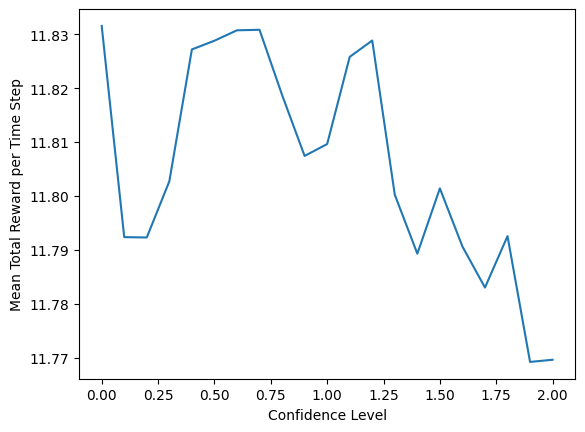

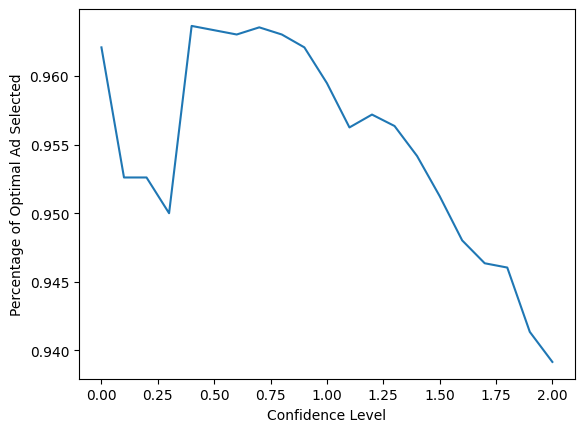

In [ ]:
plt.plot(confidence_levels, mean_rewards_per_param)
plt.xlabel('Confidence Level')
plt.ylabel('Mean Total Reward per Time Step')
plt.show()

plt.plot(confidence_levels, percent_optimal_mab_selected_per_param)
plt.xlabel('Confidence Level')
plt.ylabel('Percentage of Optimal Ad Selected')
plt.show()

In [ ]:
time_step = 120
experiment = UCB_Experiment(UCB_MAB, true_means, 0.6)
experiment.run(time_step)

In [ ]:
Counter(experiment.mabs_selected)

Counter({2: 1, 1: 1, 0: 1, 3: 2, 4: 115})

In [ ]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

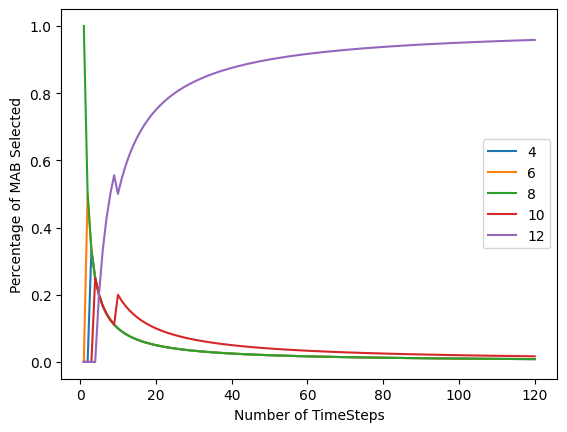

In [ ]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

## UCB1 Algorithm
Dervied from Hoeffding's inequality,
$P(Q(a) > Q_{t}(a) + u_{t}(a)) \leq e^{-2tu_{t}^2(a)}$

where $u_{t}(a)$ is an upper confidence bound depending on timestep t and action a

Set $p = e^{-2tu_{t}^2(a)}$ for small p,

we get $ u_{t}(a) = \sqrt\frac{-\log p}{2N_{t}(a)}$

For UCB1, further substitute $p = t^{-4}$ in the hope to reduce p a lot in time t

In [ ]:
# Substitute c = sqrt(2)
time_step = 120
experiment = UCB_Experiment(UCB_MAB, true_means, np.sqrt(2))
experiment.run(time_step)

In [ ]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

In [ ]:
Counter(experiment.mabs_selected)

Counter({2: 1, 1: 1, 3: 4, 0: 1, 4: 113})

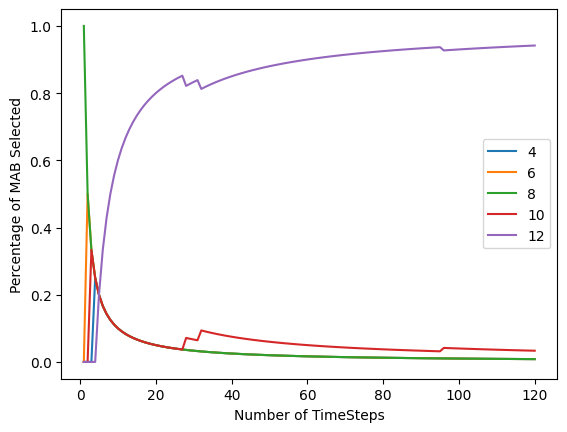

In [ ]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

## Bayesian UCB Algorithm
Assume prior knowledge on sample distribution - normal distribution
Then can further simplify upper confidence bound $u_{t}(a)$ to $c \frac{\sigma}{\sqrt{N_{t}(a)}}$, where $\sigma$ is the sample standard deviation.
Setting $c = 1.96$, it gives us the upper 95% confidence interval.

In [ ]:
# Assuming the MAB rewards are normally distributed, we can set c = 1.96 to get the 95% confidence upper bound
time_step = 120
experiment = UCB_Experiment(UCB_MAB, true_means, 1.96)
experiment.run(time_step)

In [ ]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

In [ ]:
Counter(experiment.mabs_selected)

Counter({3: 3, 4: 114, 2: 1, 1: 1, 0: 1})

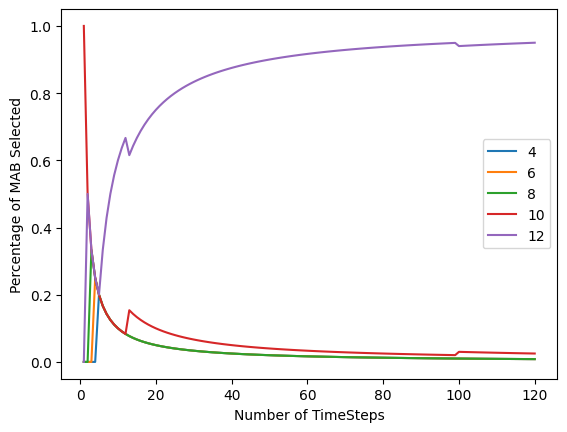

In [ ]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

# Thompson Sampling Algorithm

## Bernoulli Thompson Sampling Algorithm
Prior Belief is Beta Distribution: $Β(1, 1)$

Likelihood is Bernoulli Distribution: $\text{Bernoulli}(p)$

After $k$ successes and $n - k$ failures

Posterior Distribution is Beta Distribution: $Β(1 + k, 1 + n - k)$

Posterior Predictive is Bernoulli Distribution: $\text{Bernoulli}\big(\frac{1 + k}{2 + n}\big)$

In [8]:
class Bernoulli_Thompson_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.alpha = 1
       self.beta = 1

    def return_reward(self):

        return np.random.random() < self.true_mean

    def update(self, reward):
        #there is no estimated mean. Instead of estimated mean, we update alpha and beta
        #which models the posterior distribution of the parameter p given observed samples
        self.n_steps += 1
        self.alpha += reward
        self.beta += (1 - reward)


In [9]:
class Bernoulli_Thompson_Experiment(Base_Experiment):
    def select(self):
        current_means = [np.random.beta(mab.alpha, mab.beta) for mab in self.mabs]
        max_index = random_argmax(current_means)
        return max_index

In [10]:
true_means = [0.1, 0.3, 0.5, 0.7, 0.9]
time_step = 120
experiment = Bernoulli_Thompson_Experiment(Bernoulli_Thompson_MAB, true_means)
experiment.run(time_step)

In [12]:
Counter(experiment.mabs_selected)

Counter({0: 3, 3: 24, 1: 2, 2: 15, 4: 76})

In [11]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

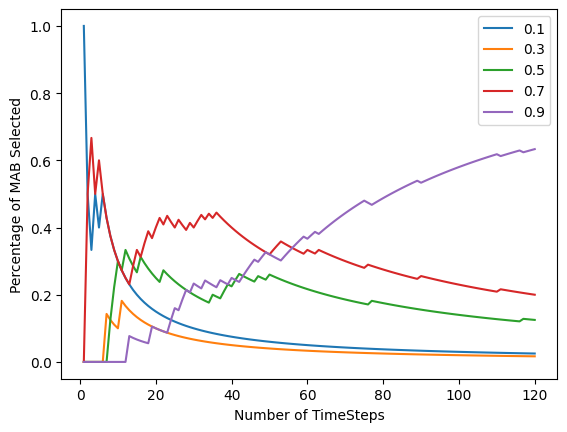

In [13]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

##Gaussian Thompson Sampling Algorithm

In [18]:
#Assume known variance of 1
#tau = posterior precision = 1/variance
#miu = posterior mean

class Gaussian_Thompson_MAB(Base_MAB):
    def __init__(self, true_mean, *args):
       super().__init__(true_mean, *args)
       self.tau = 0.0001
       self.miu = 1.0

    def update(self, reward):
        super().update(reward)
        self.miu = (self.tau * self.miu + self.n_steps * self.estimate_mean)/(self.tau + self.n_steps)
        self.tau += 1


In [19]:
class Gaussian_Thompson_Experiment(Base_Experiment):
    def select(self):
        current_means = [np.random.randn()/np.sqrt(mab.tau) + mab.miu for mab in self.mabs]
        max_index = random_argmax(current_means)
        return max_index

In [20]:
true_means = [k*2 + 2 for k in range(1, 6)]
time_step = 120
experiment = Gaussian_Thompson_Experiment(Gaussian_Thompson_MAB, true_means)
experiment.run(time_step)

In [21]:
Counter(experiment.mabs_selected)

Counter({0: 1, 3: 5, 1: 1, 2: 1, 4: 112})

In [22]:
percent_mabs_selected = percent_mabs_selected_per_timestep(experiment, time_step)

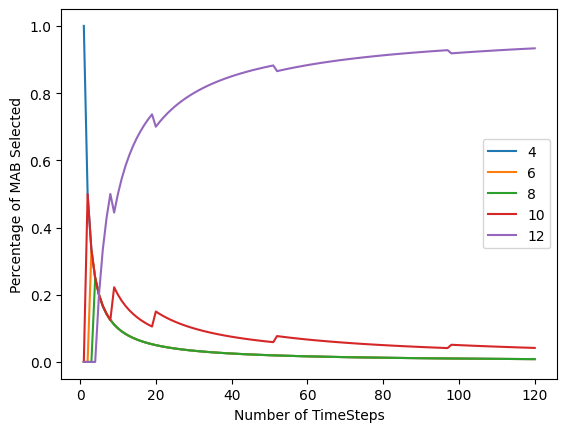

In [23]:
plt.plot(range(1, time_step + 1), percent_mabs_selected)
plt.xlabel('Number of TimeSteps')
plt.ylabel('Percentage of MAB Selected')
plt.legend(true_means)
plt.show()

#Comparison